<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import cobra
import cofactors
import seaborn as sb
import matplotlib.pyplot as pp
import pandas as pd
from pathlib import Path

In [2]:
sb.set_context("paper")

cobra.io.sbml.validate_sbml_model(model_file)

In [3]:
mitocore_path = Path('../external_data/mitocore')
model_file = mitocore_path / 'mitocore_v1.01.xml'
model = cobra.io.read_sbml_model(str(model_file))
model.solver = 'gurobi'
objectives = [r for r in model.reactions if r.id.startswith('OF_')]
model.objective = objectives[0]

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-27


SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_10fthf_c "10-Formyltetrahydrofolate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_c "10-Formyltetrahydrofolate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_10fthf_m "10-Formyltetrahydrofolate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_m "10-Formyltetrahydrofolate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of CHARGE in the notes element is discouraged, use fbc:charge in

In [4]:
mappings = cofactors.create_mappings_ec_mitocore_from_xml(model_file)
km_folder = Path("../generated_data/")
sabio_files = (km_folder / "sabiork_queries").glob("*")
brenda_files = (km_folder / "brenda_queries").glob("*")
kms_sabio = cofactors.read_sabiork(sabio_files)
kms_brenda = cofactors.read_brenda(brenda_files)
kms_brenda = kms_brenda[kms_brenda.value > 0.]
subsystems = cofactors.read_subsystems(mitocore_path / "subsystems.csv")

# Brenda and SabioRK list concentrations as mM
c_start = {'Cytosol': 1., 'Mitochondrion': 2.}
c_mito = {'Cytosol': .066, 'Mitochondrion': .023}

No mapping found for AMCOXO
No mapping found for AMCOXO2_MitoCore
ECs found for 102 reactions.
No ECs found for 0 reactions.


In [5]:
folder = Path('../generated_models/')
mitoparp = cobra.io.read_sbml_model(folder / 'gimme_mito.xml')

In [6]:
models = []
steps = 500
fva_frac = .8
for i in range(1, steps+1):
    factor = i / steps
    c = {comp: cs * factor for comp, cs in c_start.items()}
    model_c = cofactors.create_models_fva(mitoparp, mappings, kms_brenda, c, c_mito, obj_frac=fva_frac)
    models.append((c, model_c))

Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmptfmh5j_w.lp
Reading time = 0.01 seconds
: 369 rows, 924 columns, 3792 nonzeros
Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmp0g1r4_tm.lp
Reading time = 0.01 seconds
: 369 rows, 924 columns, 3792 nonzeros
Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmpt13yfix9.lp
Reading time = 0.02 seconds
: 369 rows, 924 columns, 3792 nonzeros
Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmpt3j5zyho.lp
Reading time = 0.01 seconds
: 369 rows, 924 columns, 3792 nonzeros
Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmp0iz9c3v4.lp
Reading time = 0.01 seconds
: 369 rows, 924 columns, 3792 nonzeros
Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmpbqohauea.lp
Reading time = 0.01 seconds
: 369 rows, 924 columns, 3792 nonzeros
Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmpmxybzxaw.lp
Reading time = 0.01 seconds
: 369 rows

In [7]:
sols_p = [(m[0], cobra.flux_analysis.pfba(m[1], .99)) for m in models]
sols = [(m[0], m[1].optimize()) for m in models]

In [8]:
obj = [(m[0], m[1].objective_value) for m in sols]

In [9]:
sb.set(
    font_scale = 1.2,
    style = 'whitegrid'
)

In [10]:
xlabel = 'assumed wt NAD concentration $C_0$ in mitochondria [mM]'

In [11]:
figpath = Path('../images/supplements')

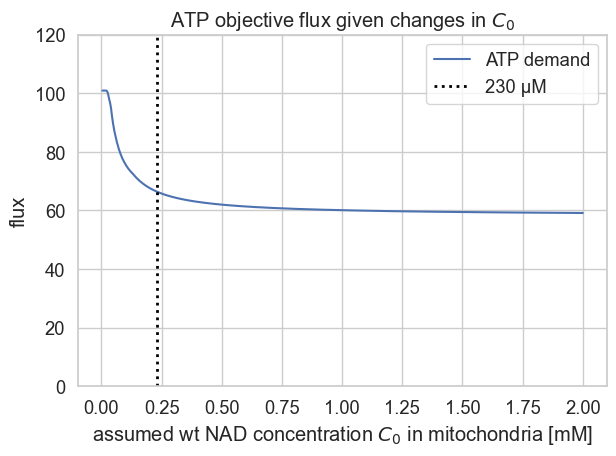

In [12]:
ax = sb.lineplot(
    x = [m[0]['Mitochondrion'] for m in obj],
    y = [m[1] for m in obj],
    label = 'ATP demand', 
)
ax.set_ylim(0., 120.)
ax.set_xlabel(xlabel)
ax.set_ylabel('flux')
ax.set_title('ATP objective flux given changes in $C_0$')
ax.axvline(.23, color='black', linestyle=':', linewidth=2., label='230 µM')
ax.legend()
fig = ax.get_figure()
pp.tight_layout()

In [13]:
x = [s[0]['Mitochondrion'] for s in sols]
fluxes_ldh = [s[1].fluxes['LDH_L'] for s in sols_p]
fluxes_ac16 = [s[1].fluxes['ACADLC16_MitoCore'] for s in sols_p]
fluxes_ac14 = [s[1].fluxes['ACADLC14_MitoCore'] for s in sols_p]
fluxes_mtp14 = [s[1].fluxes['MTPC14_MitoCore'] for s in sols_p]
fluxes_mtp16= [s[1].fluxes['MTPC16_MitoCore'] for s in sols_p]
fluxes_pcm= [s[1].fluxes['PCm'] for s in sols_p]

sum_acs = [fluxes_ac14[i] + fluxes_ac16[i] for i in range(len(fluxes_ac14))]
sum_mtps = [fluxes_mtp14[i] + fluxes_mtp16[i] for i in range(len(fluxes_ac14))]

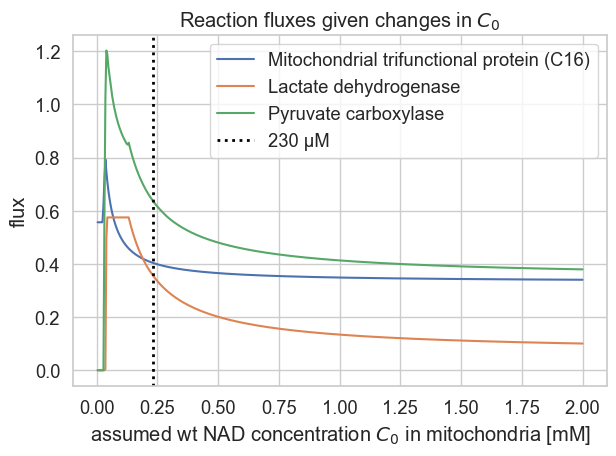

In [14]:
ax = sb.lineplot(
    x=x, 
    y=fluxes_mtp16, 
    label='Mitochondrial trifunctional protein (C16)'
)
ax.plot(
    x, 
    fluxes_ldh, 
    label='Lactate dehydrogenase'
    )
ax.plot(
    x, 
    fluxes_pcm, 
    label = 'Pyruvate carboxylase'
    )
ax.set_xlabel(xlabel)
ax.set_ylabel('flux')
ax.set_title('Reaction fluxes given changes in $C_0$')
ax.axvline(.23, color='black', linestyle=':', linewidth=2., label='230 µM')
ax.legend()
fig = ax.get_figure()
pp.tight_layout()